In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder

In [2]:
#loading train_data and divide them into different array: alertkey, custinfo, dp_5_arr
train_data = np.load("train_set_5.npy",allow_pickle = True)
print(train_data.shape)
alert_key_arr = train_data[:,0]

custinfo_arr = train_data[:,1]
custinfo_arr = np.array([np.array(i) for i in custinfo_arr]) #convert all into array

dp_5_arr = train_data[:,2]
dp_5_arr = np.array([np.array(i) for i in dp_5_arr]) #convert all into array

ccba_5_arr = train_data[:,3]
ccba_5_arr = np.array([np.array(i) for i in ccba_5_arr]) #convert all into array

cdtx_5_arr = train_data[:,4]
cdtx_5_arr = np.array([np.array(i) for i in cdtx_5_arr]) #convert all into array

sarflag_arr = pd.read_csv("train_y_answer.csv").values
#capture the alertkey which is money laundry record
sarflag1_alertkey = np.array([row[0] for row in sarflag_arr if row[1]==1])

laundry_label = np.array([0,1])
normal_label = np.array([1,0])

sarflag_arr_double = np.array([laundry_label if row[1] == 1 else normal_label for row in sarflag_arr])


(23906, 7)


In [3]:
#shuffle the data and do train test split

#generate random_indexes(23906)
random.seed(10)
shuffle_index = [i for i in range(len(alert_key_arr))]
random.shuffle(shuffle_index)

#shuffle all the data
shuffle_alert_key = alert_key_arr[shuffle_index]
shuffle_custinfo = custinfo_arr[shuffle_index]
shuffle_dp_5 = dp_5_arr[shuffle_index]
shuffle_ccba_5 = ccba_5_arr[shuffle_index]
shuffle_cdtx_5 = cdtx_5_arr[shuffle_index]
shuffle_sarflag = sarflag_arr_double[shuffle_index]



#train_test_split
split_ratio = 0.8
split_index = int(len(alert_key_arr) * split_ratio)

train_alert_key = shuffle_alert_key[:split_index] #其實用不到
test_alert_key = shuffle_alert_key[split_index:]

train_custinfo = shuffle_custinfo[:split_index]
test_custinfo = shuffle_custinfo[split_index:]

train_dp_5 = shuffle_dp_5[:split_index,:]
test_dp_5 = shuffle_dp_5[split_index:,:]

train_ccba_5 = shuffle_ccba_5[:split_index,:]
test_ccba_5 = shuffle_ccba_5[split_index:,:]

train_cdtx_5 = shuffle_cdtx_5[:split_index,:]
test_cdtx_5 = shuffle_cdtx_5[split_index:,:]

train_sarflag = shuffle_sarflag[:split_index]
test_sarflag = shuffle_sarflag[split_index:]

In [4]:
#find test_alertkey which is money laundry record
test_laundry_alertkey = [key for key in test_alert_key if key in sarflag1_alertkey]
print("test money laundry alert key:",test_laundry_alertkey)
print("len of test laundry records:",len(test_laundry_alertkey))

test money laundry alert key: [257373, 238500, 194998, 347894, 196768, 193591, 242265, 222762, 217767, 208521, 228779, 216430, 192624, 210477, 194991, 302634, 198064, 184729, 199069, 200734, 215398, 306458, 313558, 275937, 185217, 256370, 216871, 194029, 198709, 218840, 279637, 257351, 283568, 204801, 224975, 274321, 214818, 195765, 202146, 220868, 187020, 178503, 298380, 204639, 305491, 190233, 269661, 189123, 316664, 216405, 246756]
len of test laundry records: 51


In [5]:
#calculate class weight:
neg = 0
pos = 0
total = len(train_sarflag)

for label in train_sarflag:
    if label[0] == 1:
        neg += 1
    else:
        pos += 1

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)/(3/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.5048307903489784, 1: 34.834244080145716}


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input
#https://keras.io/api/layers/core_layers/input/
from tensorflow.keras.layers import concatenate

In [7]:
METRICS = [
      tf.keras.metrics.Recall(name='recall'),
]


In [8]:
def model_phase():
    
    #define input_shape
    custinfo_input = Input(shape=(train_custinfo.shape[1]))
    dp_input = Input(shape=train_dp_5.shape[1:])
    ccba_input = Input(shape=train_ccba_5.shape[1:])
    cdtx_input = Input(shape=train_cdtx_5.shape[1:])
    
    
    
    dp_embedding = LSTM(train_dp_5.shape[2],activation="relu")(dp_input)
    dp_embedding = Dropout(0.5)(dp_embedding)
    
    ccba_embedding = LSTM(train_ccba_5.shape[2],activation="relu")(ccba_input)
    ccba_embedding = Dropout(0.5)(ccba_embedding)
    
    cdtx_embedding = LSTM(train_cdtx_5.shape[2],activation="relu")(cdtx_input)
    cdtx_embedding = Dropout(0.5)(cdtx_embedding)
    
    
    concat_embedding = concatenate([custinfo_input,dp_embedding,ccba_embedding,cdtx_embedding])
    
    out64 = Dense(64, activation="relu")(concat_embedding)
    
    #out32 = Dense(32, activation="relu")(out64)
    
    #out16 = Dense(16, activation="relu")(out64)
    
    #out8 = Dense(8, activation="relu")(out16)
    
    #out4 = Dense(4, activation="relu")(out8)
    
    out2 = Dense(2, activation="softmax")(out64)

    model = Model(inputs=[custinfo_input, dp_input,ccba_input,cdtx_input], outputs=out2)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer='adam',
            metrics=METRICS)
    print(model.summary())
    #callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    # 進行訓練
    history = model.fit([train_custinfo,train_dp_5,train_ccba_5,train_cdtx_5], 
                        train_sarflag, 
                        epochs = 10, 
                        batch_size = 64,
                        class_weight=class_weight,
                        #callbacks=[callback],
                        validation_data=([test_custinfo,test_dp_5,test_ccba_5,test_cdtx_5]
                                         ,test_sarflag))  
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss,"-b")
    plt.plot(val_loss,"-r")
    plt.title("loss trend")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    plt.plot(recall,"-b")
    plt.plot(val_recall,"-r")
    plt.title("recall trend")
    plt.xlabel("epoch")
    plt.ylabel("recall")
    plt.show()

    
    
    y_pred = model.predict([test_custinfo,test_dp_5,test_ccba_5,test_cdtx_5])
    
    return y_pred

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 89)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5, 7)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5, 184)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 89)           63724       input_2[0][0]                    
______________________________________________________________________________________________

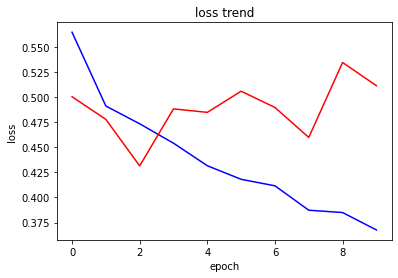

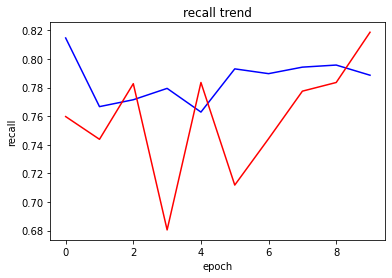

In [9]:
pred = model_phase()

In [10]:
from sklearn.metrics import classification_report

y_pred = [0 if label[0]> label[1] else 1 for label in pred]
y_true = [0 if label[0]> label[1] else 1 for label in test_sarflag]

print(classification_report(y_true,y_pred))
print(len(pred))

y_pred_index = [i for i in range(len(y_pred)) if y_pred[i]==1]
y_true_index = [i for i in range(len(y_true)) if y_true[i]==1]
print("predict index:",y_pred_index)
print("true index:",y_true_index)

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      4731
           1       0.03      0.59      0.06        51

    accuracy                           0.82      4782
   macro avg       0.51      0.70      0.48      4782
weighted avg       0.98      0.82      0.89      4782

4782
predict index: [10, 11, 13, 17, 36, 37, 44, 57, 59, 60, 61, 63, 71, 73, 74, 75, 85, 90, 98, 109, 112, 120, 123, 125, 128, 148, 155, 160, 164, 173, 174, 176, 184, 192, 203, 217, 219, 224, 236, 244, 247, 248, 259, 264, 279, 285, 286, 293, 297, 304, 307, 310, 327, 328, 329, 335, 337, 338, 339, 341, 342, 343, 345, 347, 348, 349, 360, 362, 374, 375, 382, 385, 391, 392, 399, 404, 423, 425, 433, 434, 439, 446, 448, 450, 457, 461, 472, 483, 488, 498, 500, 503, 505, 508, 510, 513, 514, 521, 524, 542, 547, 548, 556, 557, 559, 566, 580, 587, 596, 597, 598, 603, 605, 609, 619, 631, 644, 645, 655, 661, 663, 669, 672, 685, 686, 717, 719, 722, 734, 735, 736, 739, 741, 747, 7

In [11]:
def capture_sarflags_cost(real_laundry_key,y_pred,shuffle_alert_key):
    
    #concat alertkey with predicted probability
    alert_key_with_prob = np.hstack((np.array(shuffle_alert_key).reshape(-1,1),
                                     y_pred.reshape(-1,1)))
    
    #sorted by probability
    alert_key_with_prob = np.array(sorted(alert_key_with_prob, key=lambda x: x[1],reverse=True))
    #capture only index
    sorted_alert_key = alert_key_with_prob[:,0].tolist()
    
    distance = [0,0]
    for index in real_laundry_key:
        if distance[1] < sorted_alert_key.index(index):
            distance[0] = distance[1]
            distance[1] = sorted_alert_key.index(index)
        else:
            distance[0] = max(distance[0],sorted_alert_key.index(index))
    
    print(distance)
    precision = (len(real_laundry_key)-1)/distance[0]
    print(precision)
    
capture_sarflags_cost(test_laundry_alertkey,pred[:,1],test_alert_key)

[4597, 4670]
0.010876658690450293
